# Classification task

In [1]:
# installation of packages
!pip install nltk

In [2]:
# installation of NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data pre-processing

In [3]:
# Loading data
import ast
import pandas as pd

# reading the dataset 
df = pd.read_csv('../data/dataset_refiltered_9_labels.csv')

# getting the list of genres 
genres = set()
for v in df['genres'].values: genres = set(list(genres) + ast.literal_eval(v))
genres = list(genres)

# creating the mappings from genres to id and vice versa
genre2id = {k:v for (v, k) in enumerate(genres)}
id2genre = {k:v for (k, v) in enumerate(genres)}

df.head()

,Unnamed: 0.1,Unnamed: 0,wiki_id,frbs_id,name,author,date,genres,summary
0,0,0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"['realistic fiction', ""children's literature""]","Old Major, the old boar on the Manor Farm, cal..."
1,1,1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,['science fiction'],"Alex, a teenager living in near-future England..."
2,2,2,986,/m/0ldx,The Plague,Albert Camus,1947,['realistic fiction'],The text of The Plague is divided into five pa...
3,3,3,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"['science fiction', 'fantasy']",The novel posits that space around the Milky W...
4,4,4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"['realistic fiction', 'historical']","The book tells the story of Paul Bäumer, a Ger..."


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df['summary'].to_numpy() # corpus - predictor variables
Y = np.full((X.shape[0], len(genres)), 0, dtype=int) # genres - target variables

# populating Y

genre_data = df['genres'].to_numpy() # genres assigned to works
for idx in range(len(Y)):
    genre_data[idx] = ast.literal_eval(genre_data[idx])
    for g in genre_data[idx]: Y[idx][genre2id[g]] = 1


In [5]:
%%script false --no-raise-error
# Search of optimal value for min_df

for val in [0, 0.000625, 0.00125, 0.001875, 0.0025, 0.005, 0.01]:
    opt_X_train, opt_X_test, opt_Y_train, opt_Y_test = train_test_split(X, Y, random_state=2023)
    vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=val)
    base_twcnb = ComplementNB()
    clf_twcnb = OneVsRestClassifier(base_twcnb)
    opt_X_train = vectorizer.fit_transform(opt_X_train)
    opt_X_test = vectorizer.transform(opt_X_test)
    clf_twcnb.fit(opt_X_train, opt_Y_train)
    print(f'{val * 100: .2f}% -> {clf_twcnb.score(X_test, Y_test)}')

# 0% -> 0.060659186535764374
# 0.0625% -> 0.2699859747545582
# 0.125% -> 0.3159186535764376 < OPTIMAL >
# 0.1875% -> 0.3075035063113605
# 0.25% -> 0.28856942496493687
# 0.5% -> 0.22300140252454417
# 1.0% -> 0.15252454417952313

Couldn't find program: 'false'


In [6]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# defining tokenizer which performs lemmatization and skips stop or/and non-alphabetic words
class LemmaTokenizer:
    def __init__(self):
        self.stops = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t).lower() for t in word_tokenize(doc) if self.wnl.lemmatize(t) not in self.stops and t.isalpha()]
    
# defining TF-IDF vectorizer
# we put threshold of 1% for term presence in summaries so we can filter out the least common terms
# which can cause the overfitting of the classifier (this choice is backed by Zipf's law)
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.00125)

## Classifiers

In [7]:
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV, cross_validate, KFold

from sklearn.metrics import make_scorer, accuracy_score, hamming_loss

from datetime import datetime
from scipy.stats import randint
import pickle
import os

In [8]:
# report performance
def report_performance_on_test_sets(scores):
    import numpy as np
    
    print('F1 micro score: mean = %.3f, standard deviation = %.3f' %(np.mean(scores['test_F1 micro']), 
                                                                 np.std(scores['test_F1 micro'])))
    
    print('Accuracy: mean = %.3f, standard deviation = %.3f' %(np.mean(scores['test_Accuracy']), 
                                                                 np.std(scores['test_Accuracy'])))
    
    print('Hamming loss: mean = %.3f, standard deviation = %.3f' %(np.mean(scores['test_Hamming loss']), 
                                                                 np.std(scores['test_Hamming loss'])))
    


### Multinomial Naive Bayes

In [9]:
st=datetime.now() 

# defining the model and fitting
base_twcnb = ComplementNB()
clf_twcnb = OneVsRestClassifier(base_twcnb)

steps = list()
steps.append(('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.00125)))
steps.append(('model', clf_twcnb))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, shuffle=True, random_state=2023)

scoring = {"F1 micro": "f1_micro", "Accuracy": make_scorer(accuracy_score), 
           "Hamming loss": make_scorer(hamming_loss)}

mnb_scores = cross_validate(pipeline, X=X, y=Y, cv=cv, scoring = scoring, return_estimator = True)

print("Time taken to perform multiple model evaluation: ",datetime.now()-st)
report_performance_on_test_sets(mnb_scores)

Time taken to perform multiple model evaluation:  0:07:06.878018
F1 micro score: mean = 0.605, standard deviation = 0.005
Accuracy: mean = 0.367, standard deviation = 0.013
Hamming loss: mean = 0.112, standard deviation = 0.002


In [13]:
cwd = os.getcwd()
print(cwd)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!CHANGE ACCORDINGLY!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
os.chdir('..')

C:\Users\User\OneDrive - UT Cloud\Python code\dl_git\automatic-book-genre-classification\code


In [14]:
with open('./data/scores/redgenres/MNB_scores_red.pkl', 'wb') as f:
    pickle.dump(mnb_scores, f)
        
#with open('./data/scores/allgenres/MNB_scores.pkl', 'rb') as f:
#    MNB_scores = pickle.load(f)

### Logistic regression

In [10]:
def tune_and_evaluate_model(model, param_space, X, Y):
    
    # define the pipeline
    steps = list()
    steps.append(('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.00125)))
    steps.append(('model', model))
    pipeline = Pipeline(steps=steps)

    inner_cv = KFold(n_splits=2, shuffle=True, random_state=2023) # for hyperparameter tuning
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=2023)

    #defining scoring for k fold cross validation
    scoring = {"F1 micro": "f1_micro", "Accuracy": make_scorer(accuracy_score), 
               "Hamming loss": make_scorer(hamming_loss)}

    # Nested CV with parameter optimization
    # for  hypoparameter tuning f1 score will be used to find the best parameters for refitting the 
    # estimator at the end. It is specified with the parameter refit = 'F1 micro'.
    clf = RandomizedSearchCV(pipeline, param_space, n_iter=3, scoring = scoring, cv = inner_cv, 
                             refit = 'F1 micro')
    
    scores = cross_validate(clf, X=X, y=Y, cv=outer_cv, return_estimator = True, scoring = scoring)

    # report performance
    report_performance_on_test_sets(scores)
    return scores

In [11]:
st=datetime.now() 

clf_lr = OneVsRestClassifier(LogisticRegression(max_iter = 200))
param_space = {
              'model__estimator__C':[0.01,0.1,1,5,10] 
              }
lr_scores = tune_and_evaluate_model(clf_lr, param_space, X, Y)

print("Time taken to perform hyperparameter tuning and multiple model evaluation: ",datetime.now()-st)

F1 micro score: mean = 0.603, standard deviation = 0.005
Accuracy: mean = 0.376, standard deviation = 0.013
Hamming loss: mean = 0.103, standard deviation = 0.002
Time taken to perform hyperparameter tuning and multiple model evaluation:  0:41:56.238711


In [15]:
with open('./data/scores/redgenres/LR_scores_red.pkl', 'wb') as g:
    pickle.dump(lr_scores, g)

In [ ]:
# with open('./data/scores/allgenres/LR_scores.pkl', 'rb') as g:
#    lr_scores = pickle.load(g)

### Random forest classifier
Inherently supports mulitilabel classification

In [12]:
st=datetime.now() 

rf = RandomForestClassifier(n_estimators = 2)

param_space = {
              'model__max_depth':list(np.arange(10, 250, step=50))
              }
rf_scores = tune_and_evaluate_model(rf, param_space, X, Y)
print("Time taken to perform hyperparameter tuning and multiple model evaluation: ",datetime.now()-st)


F1 micro score: mean = 0.258, standard deviation = 0.021
Accuracy: mean = 0.129, standard deviation = 0.013
Hamming loss: mean = 0.164, standard deviation = 0.006
Time taken to perform hyperparameter tuning and multiple model evaluation:  0:41:04.231703


In [16]:
with open('./data/scores/redgenres/RF_scores_red.pkl', 'wb') as h:
    pickle.dump(rf_scores, h)

In [ ]:
# with open('./data/scores/allgenres/RF_scores.pkl', 'rb') as h:
#    rf_scores = pickle.load(h)

### XGBoost

In [22]:
# define the classifier
st=datetime.now() 

xgboost = xgb.XGBClassifier(objective = 'multi:softmax',                                  
                            seed = 2023,  
                            num_class=2,
                            gamma =  0.1,
                            learning_rate = 0.5,
                            n_estimators = 200
                            
                         ) 
one_vs_rest_xgboost = OneVsRestClassifier(xgboost)

param_space = {
              'model__estimator__max_depth':[2, 5]
              }
xgboost_scores = tune_and_evaluate_model(one_vs_rest_xgboost, param_space, X, Y)
print("Time taken to perform hyperparameter tuning and multiple model evaluation: ",datetime.now()-st)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_sele

F1 micro score: mean = 0.560, standard deviation = 0.007
Accuracy: mean = 0.327, standard deviation = 0.011
Hamming loss: mean = 0.114, standard deviation = 0.003
Time taken to perform hyperparameter tuning and multiple model evaluation:  3:07:20.134272


In [23]:
with open('./data/scores/redgenres/XGBoost_scores_red.pkl', 'wb') as i:
    pickle.dump(xgboost_scores, i)

In [ ]:
# with open('./data/scores/allgenres/XGBoost_scores.pkl', 'rb') as i:
#    xgboost_scores = pickle.load(i)

## Evaluation of the models 

In [27]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1 (micro) score')

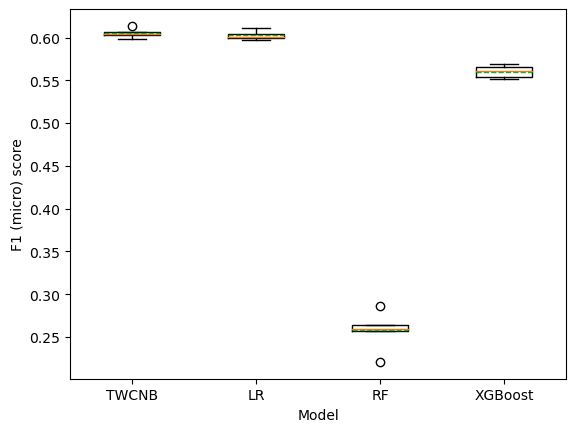

In [29]:
models_scores_f1 =  {'TWCNB': mnb_scores['test_F1 micro'], 
                     'LR': lr_scores['test_F1 micro'],
                     'RF': rf_scores['test_F1 micro'],
                     'XGBoost' : xgboost_scores['test_F1 micro']
                    }

fig, ax = plt.subplots()
ax.boxplot(models_scores_f1.values(), showmeans=True, meanline = True)
ax.set_xticklabels(models_scores_f1.keys())
ax.set_xlabel("Model")
ax.set_ylabel("F1 (micro) score")

Text(0, 0.5, 'Accuracy')

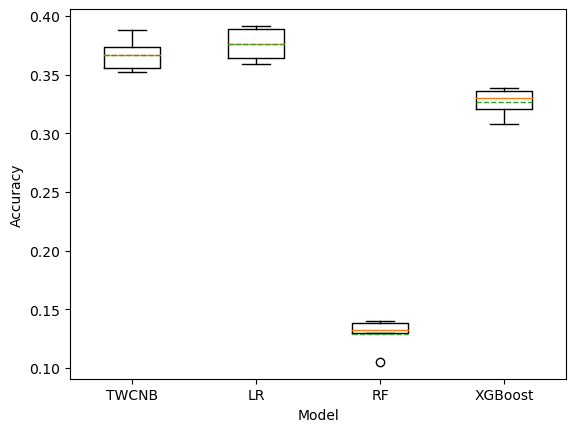

In [31]:
models_scores_accuracy = {'TWCNB': mnb_scores['test_Accuracy'], 
                 'LR': lr_scores['test_Accuracy'],
                 'RF': rf_scores['test_Accuracy'],
                 'XGBoost' : xgboost_scores['test_Accuracy']
                }

fig, ax = plt.subplots()
ax.boxplot(models_scores_accuracy.values(), showmeans=True, meanline = True)
ax.set_xticklabels(models_scores_accuracy.keys())
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'Hamming loss')

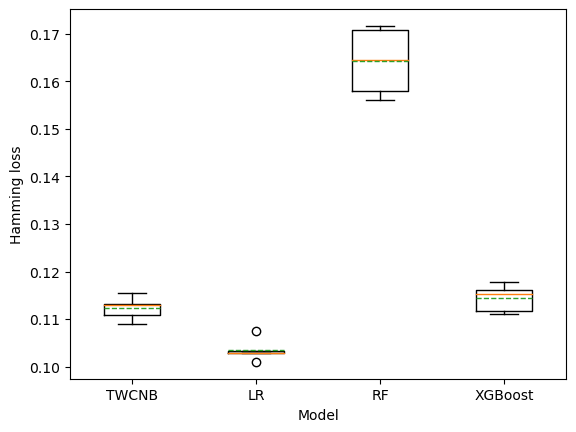

In [32]:
models_scores_hamming = {'TWCNB': mnb_scores['test_Hamming loss'], 
                         'LR': lr_scores['test_Hamming loss'],
                         'RF': rf_scores['test_Hamming loss'],
                         'XGBoost' : xgboost_scores['test_Hamming loss']
                        }

fig, ax = plt.subplots()
ax.boxplot(models_scores_hamming.values(), showmeans=True, meanline = True)
ax.set_xticklabels(models_scores_hamming.keys())
ax.set_xlabel("Model")
ax.set_ylabel("Hamming loss")